In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from warnings import filterwarnings as fw
fw("ignore")

2023-01-12 12:47:30.273766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 12:47:30.815924: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-12 12:47:30.815956: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-12 12:47:32.711782: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
(x_train,_),(x_test,_) = fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = x_train[...,tf.newaxis]
x_test = x_test[...,tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [4]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0.,clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0.,clip_value_max=1.)

2023-01-12 12:47:36.653022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-12 12:47:36.653445: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-12 12:47:36.653479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tunapc): /proc/driver/nvidia/version does not exist
2023-01-12 12:47:36.657132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 12:47:36.708077: W tensorflow/tsl/framework/cpu_allocator_impl.cc:

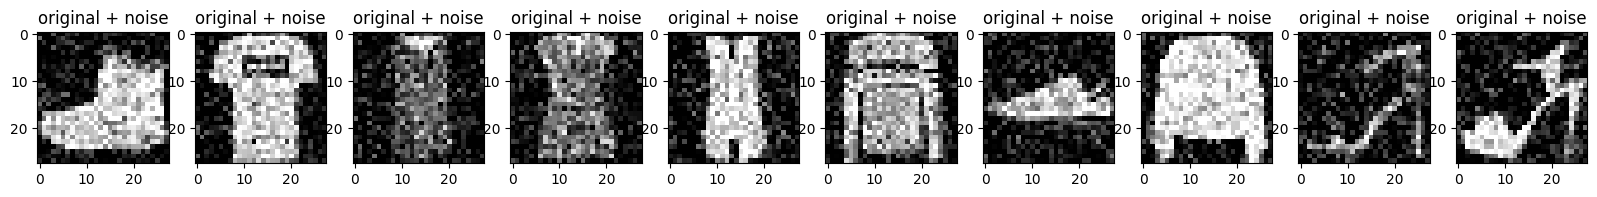

In [5]:
n = 10
plt.figure(figsize=(20,2))
for i in range(n):
    ax = plt.subplot(1,n,i+1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [6]:
class Denoise(Model):
    def __init__(self):
        super(Denoise,self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28,28,1)),
            layers.Conv2D(16,(3,3),activation="relu",padding="same",strides=2),
            layers.Conv2D(8,(3,3),activation="relu",padding="same",strides=2)
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8,kernel_size=3,strides=2,activation="relu",padding="same"),
            layers.Conv2DTranspose(16,kernel_size=3,strides=2,activation="relu",padding="same"),
            layers.Conv2D(1,kernel_size=(3,3),activation="sigmoid",padding="same")
        ])
    
    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer="adam",loss=losses.MeanSquaredError())
autoencoder.fit(x_train_noisy,x_train,
               epochs=10,
               shuffle=True,
               validation_data=(x_test_noisy,x_test_noisy))

Epoch 1/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0151 - val_loss: 0.0244
Epoch 2/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0083 - val_loss: 0.0234
Epoch 3/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0077 - val_loss: 0.0232
Epoch 4/10
1875/1875 [==============================] - 65s 35ms/step - loss: 0.0074 - val_loss: 0.0229
Epoch 5/10
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0072 - val_loss: 0.0228
Epoch 6/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0070 - val_loss: 0.0227
Epoch 7/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0069 - val_loss: 0.0228
Epoch 8/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0068 - val_loss: 0.0227
Epoch 9/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0068 - val_loss: 0.0227
Epoch 10/10
1266/1875 [===================>..........] - ETA: 14

In [ ]:
autoencoder.encoder.summary()

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()